# Side by Side API In Python: An FX Example With Interactive Widgets

In this article, I exemplify how one may use pre-existing articles (such as [Umer's](https://developers.refinitiv.com/en/article-catalog/article/instrument-pricing-analytics-volatility-surfaces-and-curves)) together to form Jupyter Python Apps working anlongside your Workspace Tiles environment using the [Refinitiv Side by Side API](https://developers.refinitiv.com/en/api-catalog/eikon/workspace-web-side-by-side-api).

1st, we will use Python functions created by Umer in his [Instrument Pricing Analytics - Volatility Surfaces and Curves](https://developers.refinitiv.com/en/article-catalog/article/instrument-pricing-analytics-volatility-surfaces-and-curves) article to create [FX Volatility Surfaces](https://www.investopedia.com/articles/stock-analysis/081916/volatility-surface-explained.asp).

2nd, we will inbed such graphs in a widget, using techniques shown in CodeBook examles (in '__ Examples __/04. Advanced UseCases/04.01. Python Apps/EX_04_01_02__WFCH_Company_Income_Statement_Waterfall.ipynb') and online (shout out to [ac24](https://stackoverflow.com/questions/50842160/how-to-display-matplotlib-plots-in-a-jupyter-tab-widget)).

3rd, we will finally incorporate this workflow with the [Refinitiv Side by Side API](https://developers.refinitiv.com/en/api-catalog/eikon/workspace-web-side-by-side-api) so that Tiles become linked with our notebook, reacting to them live (shout out to [Evgeny Kovalyov](https://github.com/zhenyakovalyov)).

In this article, we look at a simple example with an FX Quote Tile and Volatility Surfaces; but you are encouraged to use this code and work to create your own applications that work ergonomically with your workflow, whatever it may be. The techniques used bellow are very maleable, and do not have to be used specifically for Volatility Surface creation. If you have an idea in mind and would like some help to code them up, don't hesitate to submit your idea on the [Article Competition](https://docs.google.com/forms/d/e/1FAIpQLSdUk6inKvZD50MHA7qAqRC5vanlGf88oIixVePiQ1eXw5PiZw/viewform) and contact me.

## Code

In [1]:
# Basic Python libraries:
import refinitiv.dataplatform as rdp
import ipywidgets as widgets
import pandas as pd
import IPython
from IPython.display import display, clear_output

# Python libraries needed specifically for Python:
import requests
from requests.exceptions import ConnectionError
import json
import functools
import enum
from enum import Enum
import time
import queue
import threading
import logging
import lomond
from lomond import WebSocket, events as websocket_events
from lomond.persist import persist
import typing
from typing import List, Tuple, Dict, Optional, Callable, Type, ClassVar, Any, Iterable
import sys  # ' sys ' is a native Python library ('native' as in it does not need to be installed) that allows us to find details on the machine running the code and our Python version.
print("This code is running on Python version: " + sys.version)  # This line shows us the details requiered.

for i, j in zip(["Refinitiv Data Platform", "ipywidgets", "pandas", "IPython", "requests", "json", "logging", "lomond"],
                [rdp, widgets, pd, IPython, requests, json, logging, lomond]):
    print(f"The imported {i} library is of version {j.__version__}")

This code is running on Python version: 3.8.2 (tags/v3.8.2:7b3ab59, Feb 25 2020, 22:45:29) [MSC v.1916 32 bit (Intel)]
The imported Refinitiv Data Platform library is of version 1.0.0a11.post1
The imported ipywidgets library is of version 7.6.3
The imported pandas library is of version 1.2.4
The imported IPython library is of version 7.22.0
The imported requests library is of version 2.23.0
The imported json library is of version 2.0.9
The imported logging library is of version 0.5.1.2
The imported lomond library is of version 0.3.3


### Graph

As per the [Instrument Pricing Analytics (Volatility Surfaces and Curves)'s](https://developers.refinitiv.com/en/article-catalog/article/instrument-pricing-analytics-volatility-surfaces-and-curves) notebook on GitHub, [plotting_helper.ipynb](https://github.com/Refinitiv-API-Samples/Article.RDPLibrary.Python.VolatilitySurfaces_Curves/blob/master/plotting_helper.ipynb), we need to:

1st: Authenticate ourselves to the [Refinitiv Data Platform API](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis):

In [2]:
# I store my login details on a .txt file that sits along side this notebook.
# The tree lines bellow (and the complementary .close() lines at the end of this cell) fetch these credentials for me.
# This way I can authenticate myself to RDP automatically and share my code without sharing my credentials.
APP_KEY = open("AppKey.txt", "r")
RDP_LOGIN = open("RdpLogin.txt", "r")
RDP_PASSWORD = open("RdpP.txt", "r")

session = rdp.DesktopSession(  # You can try and use 'PlatformSession' instead of 'DesktopSession' if running Workspace/Eikon on your desktop in the background isn't an option, although that will negate the use of Tiles essential to this exercise.
    APP_KEY.read(),
    rdp.GrantPassword(username=RDP_LOGIN.read(),
                      password=RDP_PASSWORD.read()))
session.open()

APP_KEY.close()
RDP_LOGIN.close()
RDP_PASSWORD.close()

on_state user function on session None raised error 'GrantPassword' object is not callable


2nd: Now access the RDP endpoint we're interested in before sending a request and storing the response:

In [3]:
vs_endpoint = rdp.Endpoint(
    session,
    "https://api.edp.thomsonreuters.com/data/quantitative-analytics-curves-and-surfaces/v1/surfaces")

fx_request_body = {
    "universe": [
        {
              "underlyingType": "Fx",
              "surfaceTag": "FxVol-GBPUSD",
              "underlyingDefinition": {
                "fxCrossCode": "GBPUSD"
              },
              "surfaceLayout": {
                "format": "Matrix"
              },
              "surfaceParameters": {
                "xAxis": "Date",
                "yAxis": "Delta",
                "calculationDate": "2018-08-20T00:00:00Z",
                "returnAtm": "True"
              }
        },
        {
              "underlyingType": "Fx",
              "surfaceTag": "FxVol-EURUSD",
              "underlyingDefinition": {
                "fxCrossCode": "EURUSD"
              },
              "surfaceLayout": {
                "format": "Matrix"
              },
              "surfaceParameters": {
                "xAxis": "Date",
                "yAxis": "Delta",
                "calculationDate": "2018-08-20T00:00:00Z",
                "returnAtm": "True"
              }
        },
        {
              "underlyingType": "Fx",
              "surfaceTag": "FxVol-CHFUSD",
              "underlyingDefinition": {
                "fxCrossCode": "CHFUSD"
              },
              "surfaceLayout": {
                "format": "Matrix"
              },
              "surfaceParameters": {
                "xAxis": "Date",
                "yAxis": "Delta",
                "calculationDate": "2018-08-20T00:00:00Z",
                "returnAtm": "True"
              }
        }
    ]
}

fx_response = vs_endpoint.send_request(
    method=rdp.Endpoint.RequestMethod.POST,
    body_parameters=fx_request_body
)

# # If you wish to see the data imported, you can use the line below (comented out):
# print(json.dumps(fx_response.data.raw, indent=2))

The data above can take a while to be collected, you may want to keep it for multiple runs / debugging; I do so below using the Python library [pickle](https://docs.python.org/3/library/pickle.html):

In [4]:
# import pickle

# pickle_out = open("FxResp.pickle", "wb")
# pickle.dump(fx_response, pickle_out)
# pickle_out.close()

# # To load data in:
# pickle_in = open("FxResp.pickle","rb") # ' rb ' stand for 'read bytes'.
# fx_response = pickle.load(pickle_in)
# pickle_in.close()  # We ought to close the file we opened to allow any other programs access if they need it.

3rd: Create functions to be used subsequentally in our code:

In [5]:
def convert_delta(delta):
    if delta == 'ATM': return 0.5
    elif delta < 0: return -delta
    elif delta > 0: return 1-delta
    else: return 0.5

In [6]:
# Convert float date back to Y-m-d for the Surface y axis tick labels
def format_date(x, pos=None):
    import matplotlib.dates as dates

    return dates.num2date(x).strftime('%Y-%m-%d')  #use FuncFormatter to format dates

In [7]:
# Matplotlib requires dates in float format for surface plots.
def convert_yyyymmdd_to_float(date_string_array):
    import datetime
    import matplotlib.dates as dates

    date_float_array = []
    for date_string in date_string_array:
        if len(date_string)==10:
            date_float = dates.date2num(datetime.datetime.strptime(date_string, '%Y-%m-%d'))
        else:
            date_float = dates.date2num(datetime.datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%SZ'))
        date_float_array.append(date_float)
    return date_float_array

In [8]:
def plot_surface(surfaces, surfaceTag, delta_plot=False):

    # This import registers the 3D projection, but is otherwise unused.
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import cm
    import matplotlib.ticker as ticker  # import LinearLocator, FormatStrFormatter

    surfaces = pd.DataFrame(data=surfaces)
    surfaces.set_index('surfaceTag', inplace=True)
    surface = surfaces[surfaces.index == surfaceTag]['surface'][0]

    strike_axis = surface[0][1:]
    surface = surface[1:]
    time_axis = []
    surface_grid = []
    for line in surface:
        time_axis.append(line[0])
        surface_grid_line = line[1:]
        surface_grid.append(surface_grid_line)

    time_axis = convert_yyyymmdd_to_float(time_axis)

    if delta_plot:
        # When plotting FX Delta rather than Strike
        # I'm converting the x axis value from Delta to Put Delta
        delta_axis = list(map(convert_delta, strike_axis))
        x = np.array(delta_axis, dtype=float)
    else:
        x = np.array(strike_axis, dtype=float)

    y = np.array(time_axis, dtype=float)
    Z = np.array(surface_grid, dtype=float)

    X, Y = np.meshgrid(x,y)

    fig = plt.figure(figsize=[15, 10])

    ax = plt.axes(projection='3d')
    ax.set_facecolor('0.25')
    ax.set_xlabel('Delta' if delta_plot else 'Moneyness', color='y', labelpad=10)
    ax.set_ylabel('Expiry', color='y', labelpad=15)
    ax.set_zlabel('Volatilities', color='y')
    ax.tick_params(axis='both', colors='w')

    ax.w_yaxis.set_major_formatter(ticker.FuncFormatter(format_date))

    title = 'Vol Surface for : ' + str(surfaceTag)
    ax.set_title(title, color='w')

    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    plt.show()

Now let's have a look at our retreived data:

In [9]:
pd.DataFrame(fx_response.data.raw['data'][0]['surface'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,None,-0.100000,-0.150000,-0.200000,-0.250000,-0.300000,-0.350000,-0.400000,-0.450000,ATM,0.450000,0.400000,0.350000,0.300000,0.250000,0.200000,0.150000,0.100000
1,2018-08-21T00:00:00Z,8.474051,8.287048,8.150250,8.042252,7.953471,7.878892,7.815711,7.762395,7.718295,7.683482,7.658827,7.646259,7.649327,7.674480,7.734006,7.853826,8.099067
2,2018-08-27T00:00:00Z,7.216783,7.039678,6.904175,6.792778,6.698002,6.616572,6.547623,6.491790,6.45,6.421648,6.404364,6.395211,6.391767,6.392500,6.396667,6.404258,6.416331
3,2018-09-20T00:00:00Z,8.721474,8.428308,8.205749,8.023586,7.868376,7.733312,7.614962,7.511977,7.425,7.354327,7.300886,7.265785,7.248489,7.247751,7.262654,7.293985,7.346819
4,2018-10-18T00:00:00Z,9.754180,9.359295,9.068374,8.836522,8.643445,8.478312,8.334787,8.209012,8.1,8.004928,7.922659,7.855354,7.805233,7.776645,7.777798,7.825129,7.956873
5,2018-11-21T00:00:00Z,10.631680,10.127494,9.762631,9.476471,9.241627,9.043442,8.873268,8.725738,8.6,8.490940,8.396015,8.318135,8.259230,8.223609,8.220009,8.267040,8.411010
6,2019-02-20T00:00:00Z,11.563453,10.950904,10.503116,10.148948,9.856185,9.607573,9.392953,9.206058,9.05,8.913807,8.791707,8.691411,8.615521,8.569554,8.564325,8.622073,8.795714
7,2019-05-20T00:00:00Z,12.110925,11.455185,10.974528,10.593206,10.276880,10.007125,9.773058,9.567921,9.4,9.251361,9.111667,8.994010,8.900850,8.837673,8.815542,8.857692,9.020572
8,2019-08-20T00:00:00Z,12.494480,11.814345,11.302635,10.886972,10.534973,10.229964,9.963114,9.730338,9.55,9.397377,9.261857,9.164729,9.105769,9.082817,9.093587,9.138595,9.226331
9,2020-08-20T00:00:00Z,12.614147,11.998540,11.531418,11.148293,10.820182,10.532073,10.276039,10.048662,9.85,9.682685,9.549920,9.452263,9.385890,9.344372,9.321684,9.313958,9.320488


Notice that sometimes you may have a `ATM` value returned; this is something dealt with in our `convert_delta` function defined previously.

Now let's plot our volatility surfaces:

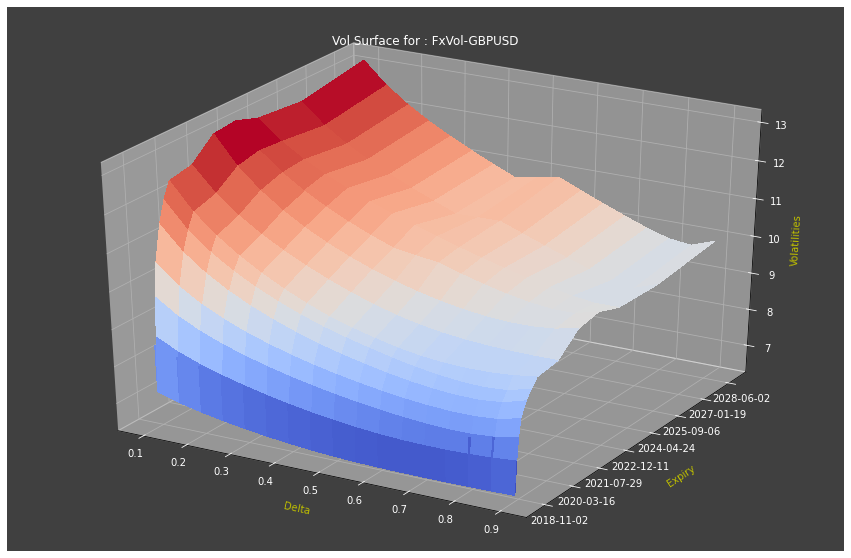

In [10]:
fx_surfaces = fx_response.data.raw['data']
surfaces, surfaceTag, delta_plot = fx_surfaces, 'FxVol-CHFUSD', False

fx_surfaces = fx_response.data.raw['data']
plot_surface(fx_surfaces, 'FxVol-GBPUSD', True)

### Widget

(Credit to [ac24](https://stackoverflow.com/questions/50842160/how-to-display-matplotlib-plots-in-a-jupyter-tab-widget))

We can now look into incorporating our above graph in a widget that allows us to toggle between graph and data (in a table). This is a rudimentary example taken from CodeBook examles (in '__ Examples __/04. Advanced UseCases/04.01. Python Apps/EX_04_01_02__WFCH_Company_Income_Statement_Waterfall.ipynb'), but more complex ones can ealisy be constructed to fit your workflow.

In [11]:
%matplotlib inline
import ipywidgets as widgets

out1 = widgets.Output()
out2 = widgets.Output()
out3 = widgets.Output()
out4 = widgets.Output()
out5 = widgets.Output()
out6 = widgets.Output()

tab = widgets.Tab(children=[out1, out2, out3, out4, out5, out6])
tab.set_title(0, 'GBPUSD Surface')
tab.set_title(1, 'GBPUSD Table')
tab.set_title(2, 'EURUSD Surface')
tab.set_title(3, 'EURUSD Table')
tab.set_title(4, 'CHFUSD Surface')
tab.set_title(5, 'CHFUSD Table')
display(tab)

fx_surfaces = fx_response.data.raw['data']
surfaces = fx_surfaces
delta_plot = False

with out1:
    fxplot = plot_surface(fx_surfaces, 'FxVol-GBPUSD', True)
with out2:
    display(pd.DataFrame(fx_response.data.raw['data'][0]['surface']))

with out3:
    fxplot = plot_surface(fx_surfaces, 'FxVol-EURUSD', True)
with out4:
    display(pd.DataFrame(fx_response.data.raw['data'][1]['surface']))

with out5:
    fxplot = plot_surface(fx_surfaces, 'FxVol-CHFUSD', True)
with out6:
    display(pd.DataFrame(fx_response.data.raw['data'][2]['surface']))

## SxS

We'll need to create functions to be used subsequentally in our code:

In [12]:
import re
exp = re.compile(r'(?!^)([A-Z])')

def to_snake_case(word: str) -> str:
    return exp.sub(r'_\1', word).lower()

def convert_dict_keys_to_snake_case(d: Dict[str, Any]) -> Dict[str, Any]:
    result = {}

    for key in d.keys():
        new_key = to_snake_case(key)
        result[new_key] = d[key]

    return result

In [13]:
class SxSErrorType(Enum):
    PARSE_ERROR = -32700
    INVALID_REQUEST = -32600
    METHOD_NOT_FOUND = -32601
    INVALID_PARAMS = -32602
    INTERNAL_ERROR = -32603
    SERVER_ERROR = -32000
    TIMEOUT = -30000
    SERVICE_NOT_FOUND = -30001
    ACCESS_DENIED = -30002

In [14]:
class SxSError(Exception):
    def __init__(self, code: int, message: str, *args) -> None:
        super().__init__(message)
        self.type = SxSErrorType(code)
        self.message = message

    def __str__(self) -> str:
        return f'{self.type}: {self.message}'

In [15]:
class Session(object):
    __instance: ClassVar[
        Optional['Session']] = None  # PEP 484, Forward references

    def __init__(self,
                 product_id: str,
                 api_key: str,
                 link_type: int,
                 session: requests.Session,
                 timeout: int,
                 url: str,
                 ping_url: str,
                 notification_url: str,
                 origin: Optional[str] = 'localhost') -> None:

        self.__url = url
        self.__ping_url = ping_url
        self.__notification_url = notification_url

        self.__session = session
        self.__timeout = timeout

        self.__session_token: Optional[str] = None
        self.__instance_id: Optional[str] = None
        self.__origin = origin

        if self.__ping():
            self.__session_token, self.__instance_id = self.__handshake(
                product_id, api_key)

            type(self).__instance = self
        else:
            raise Exception('Failed to connect to Eikon')

    def __ping(self) -> bool:
        try:
            response = self.__session.get(self.__ping_url)
        except ConnectionError:
            return False

        return response.ok

    def __handshake(self, product_id: str, api_key: str) -> Tuple[str, str]:
        payload = {
            'command': 'handshake',
            'productId': product_id,
            'apiKey': api_key
        }

        response = self.__session.post(
            self.__url, headers={'origin': self.__origin}, data=payload)

        if response.ok:
            msg = json.loads(response.text)

            if 'isSuccess' not in msg:
                raise Exception('Unexpected response')

            if msg['isSuccess']:
                return msg['sessionToken'], msg['instanceId']
            else:
                err_info = msg['error']
                raise SxSError(
                    code=err_info['code'], message=err_info['message'])
        else:
            raise Exception('Unable to perform handshake')

    def post(self, payload: Dict[str, Any]) -> Dict[str, Any]:

        if self.__session_token is None:
            raise Exception('No active side-by-side session found')

        payload['sessionToken'] = self.__session_token

        response = self.__session.post(
            self.__url, headers={'origin': self.__origin}, data=payload)
        if response.ok:
            msg = json.loads(response.text)

            if 'isSuccess' in msg:
                ok = msg.pop('isSuccess')

                if ok:
                    return convert_dict_keys_to_snake_case(msg)
                else:
                    err_info = msg['error']
                    raise SxSError(
                        code=err_info['code'], message=err_info['message'])
            else:
                raise Exception(f'Unexpected response {response.text}')
        else:
            raise Exception(
                f'Unexpected response status {response.status_code}')

    @property
    def notification_url(self) -> str:
        return self.__notification_url + f'?sessionToken={self.session_token}&linkType={3}'

    @property
    def session_token(self) -> Optional[str]:
        return self.__session_token

    @property
    def instance_id(self) -> Optional[str]:
        return self.__instance_id

    @classmethod
    def command(cls, target: Callable) -> Callable:
        @functools.wraps(target)
        def wrapper(*args, **kwargs):
            if cls.__instance:
                return cls.__instance.post(target(*args, **kwargs))
            else:
                raise Exception('No active side-by-side session found')

        return wrapper

In [16]:
class Settings(object):
    def __init__(self,
                 port_number: int = 9000,
                 timeout: int = 30,
                 link_type: Optional[str] = 'both') -> None:

        self.__port_number = port_number

        self.__ping_url = f'http://localhost:{self.__port_number}/ping'
        self.__url = f'http://localhost:{self.__port_number}/sxs/v1/'
        self.__notification_url = f'ws://localhost:{self.__port_number}/sxs/v1/notifications'
        self.__timeout = 30

        self.session = requests.Session()
        self.session.trust_env = False

    @property
    def ping_url(self):
        return self.__ping_url

    @property
    def url(self):
        return self.__url

    @property
    def notification_url(self):
        return self.__notification_url

    @property
    def timeout(self) -> int:
        return self.__timeout

In [17]:
import warnings

from typing import List, Callable, ClassVar, DefaultDict
from collections import defaultdict

__all__ = [
    'Event', 'Linked', 'Unlinked', 'ShowFeedbackForLinking',
    'HideFeedbackForLinking', 'ContextReceived', 'Allowed', 'Denied',
    'Disabled', 'WorkspaceChanged'
]


class Event(object):
    '''
    TODO: docstring
    '''
    __handlers: ClassVar[DefaultDict[str, List[Callable]]] = defaultdict(list)

    def __init__(self) -> None:
        pass

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}'

    @classmethod
    def fire(cls, *args, **kwargs) -> None:
        for handler in cls.__handlers[cls.__name__]:
            if handler:
                handler(*args, **kwargs)

    @classmethod
    def get_handler_count(cls) -> int:
        return len(cls.__handlers[cls.__name__])

    @classmethod
    def clear(cls) -> None:
        cls.__handlers[cls.__name__].clear()

    __len__ = get_handler_count


class Linked(Event):
    def __init__(self,
                 instance_id,
                 target_entity_id=None,
                 target_instance_id=None):
        self.instance_id = instance_id
        self.target_entity_id = target_entity_id
        self.target_instance_id = target_instance_id

        super().__init__()


class Unlinked(Event):
    def __init__(self,
                 instance_id,
                 target_entity_id=None,
                 target_instance_id=None):

        self.instance_id = instance_id
        self.target_entity_id = target_entity_id
        self.target_instance_id = target_instance_id

        super().__init__()


class ShowFeedbackForLinking(Event):
    def __init__(self, target_instance_id=None):
        self.target_instance_id = target_instance_id
        super().__init__()


class HideFeedbackForLinking(Event):
    def __init__(self, target_instance_id=None):
        self.target_instance_id = target_instance_id
        super().__init__()


class ContextReceived(Event):
    def __init__(self, context, instance_id=None, app_id=None):
        self.context = context
        self.instance_id = instance_id
        self.app_id = app_id
        self.target_entity_id = ''

        if 'entities' in context:
            for entity in context['entities']:
                if 'MclMetadataType' in entity:
                    if entity['MclMetadataType'] == 'contextchange-entity':
                        self.target_entity_id = entity['TargetEntityId']

        super().__init__()


class Allowed(Event):
    def __init__(self):
        super().__init__()


class Denied(Event):
    def __init__(self):
        super().__init__()


class Disabled(Event):
    def __init__(self):
        super().__init__()


class WorkspaceChanged(Event):
    def __init__(self):
        super().__init__()


In [18]:
class EventQueue(object):
    global events

    def __init__(self, url: str) -> None:
        self.__url = url
        self.__queue: queue.Queue = queue.Queue()
        self.__exit_event = threading.Event()
        self.__exception_event = threading.Event()
        self.__is_connected = threading.Event()
        self.__is_listener_attached = threading.Event()

        self.__wst = threading.Thread(
            name='EventQueuePublisher',
            target=self.__subscribe,
            args=(url, self.__queue, self.__exit_event,
                  self.__exception_event))

        self.__wst.setDaemon(True)
        self.__wst.start()
        self.__is_connected.wait(3)

    def __subscribe(self, url: str, q: queue.Queue,
                    exit_event: threading.Event,
                    exception_event: threading.Event) -> None:

        ws = WebSocket(url)

        for e in persist(ws, exit_event=exit_event):
            try:
                if isinstance(e, websocket_events.Ready):
                    self.__is_connected.set()
                elif isinstance(e, websocket_events.ConnectFail):
                    raise Exception('Websocket connection failed')
                elif isinstance(e, websocket_events.Text):
                    self.__on_text(e, q)
            except Exception as ex:
                logging.debug(str(ex))
                exception_event.set()
                ws.close()
                break

    def __on_text(self, e: websocket_events.Event, q: queue.Queue):
        if self.__is_listener_attached.is_set():
            msg = json.loads(e.text)
            cmd = msg.pop('command')
            cmd = cmd[0].upper() + cmd[1:]

            if 'context' in msg:
                msg['context'] = json.loads(msg.pop('context'))

            event: Optional[Callable] = None

            try:
                event = getattr(events, cmd)
            except AttributeError:
                logging.debug(f'Unrecognized event received: {cmd} ')

            if event:
                q.put_nowait(event(**convert_dict_keys_to_snake_case(msg)))
        else:
            if not self.__queue.empty():
                self.__clear_queue()

    def __clear_queue(self):
        self.__queue.mutex.acquire()
        self.__queue.queue.clear()
        self.__queue.all_tasks_done.notify_all()
        self.__queue.unfinished_tasks = 0
        self.__queue.mutex.release()

    def listen(self, cancel: Optional[threading.Event] = None
               ) -> Iterable[Event]:

        self.__is_listener_attached.set()

        if not cancel:
            cancel = threading.Event()

        try:
            while True:
                time.sleep(0.2)

                if cancel.is_set():
                    raise Exception('Cancellation received')

                if self.__exception_event.is_set():
                    raise Exception(
                        'Unhandled error occured in EventQueuePublisher thread'
                    )

                e: events.Event

                try:
                    e = self.__queue.get_nowait()
                except queue.Empty:
                    continue

                yield e

                if e.get_handler_count() > 0:
                    e.fire(**e.__dict__)

                self.__queue.task_done()
        except KeyboardInterrupt:
            pass
        except Exception as ex:
            logging.debug(str(ex))
        finally:
            self.__clear_queue()
            self.__is_listener_attached.clear()


In [19]:
def set_product_id_and_api_key(product_id: str,
                               api_key: str,
                               link_type: Optional[str] = 'both') -> None:

    global settings, session, eq

    link_types = {'subscriber': 1, 'publisher': 2, 'both': 3, 'disable': 4}

    if link_type not in link_types:
        raise ValueError(
            f'Incorrect value for link_type, expecting one of the following: \
            {", ".join(link_types.keys())}')

    settings = Settings()

    session = Session(
        product_id,
        api_key,
        link_type=link_types[link_type],
        session=settings.session,
        timeout=settings.timeout,
        url=settings.url,
        ping_url=settings.ping_url,
        notification_url=settings.notification_url)

    eq = EventQueue(session.notification_url)

def event_loop() -> Iterable[Event]:
    global eq
    return eq.listen()

In [20]:
# We need to set up a product ID to know what application to connect to:
set_product_id_and_api_key(
    product_id=str(open("prodid.txt", "r").read()),
    api_key=str(open("eikon.txt", "r").read()))

In [21]:
APP_ID_BY_NAME = {
    # general purpose apps
    'home': 'GxHOME',
    'my profile': 'Peopledirectory',

    # standard apps
    'quote': 'Quote',
    'monitor': 'THOMSONREUTERS.REALTIME.THINMONITOR',
    'news': 'KOxMNC',

    # charting apps
    'chart': 'Graph',
    'financial chart': 'APPxFINANCIALCHART',
    'seasonality chart': 'THOMSONREUTERS.CHARTS.SEASONALITYCHART',
    'interactive map': 'Interactive Map',

    # market apps
    'industry app': 'APPxINDUSTRY',
    'economic monitor': 'ECONOMIC_MONITOR',
    'us opinion poll': 'APPxPOLLING',
    'asset allocation': 'APPxASSETxALLOC',

    # credit and fixed income apps
    'all quotes': 'APPxCALCALLQ',
    'corporate bond prices': 'CORPORATE_BOND_PRICES',
    'bond calculator': 'APPxCALCBNDC',
    'debt structure': 'THOMSONREUTERS.FIXEDINCOME.DSAPP',
    'new issue monitor': 'THOMSONREUTERS.FIXEDINCOME.FI_NIM',
    'rates views': 'THOMSONREUTERS.FIXEDINCOME.RATESVIEWS',
    'issuer rating': 'TR.IRMI',

    # company apps
    'company overview': 'THOMSONREUTERS.COMPANY.OVERVIEW',
    'company snapshot': 'APPxCOMPSNAPSHOT',
    'company research': 'EVxAMRxCOMPANYxRESEARCH',
    'total return': 'APPxCALCTOTALRETURN',
    'corporate actions': 'EVzCORPxCORPACTCALENDAR',
    'events & transcripts': 'EVzCORPxEVENTSzEVENTS',
    'quote history': 'EVzCORPxFUNDTALSzQHSTRY',

    # dev apps
    'app to entity': 'AppToEntityDemo',
    'trade order': 'TradeOrderDemo',
    'mcl': 'MultiContextDemo',

    # other apps
    'routines': 'THOMSONREUTERS.AIM.ROUTINES',
    'portfolios and lists': 'TR.PORTFOLIOANDLIST',
    'option pricer': 'APPxCALCOPR',
    'fx polls': 'APPxFXPOLLS'
}

APP_ID_BY_CODE = {
    'q': 'Quote',
    'news': 'KOxMNC',
    'cht': 'Graph',
    'chtf': 'APPxFINANCIALCHART',
    'mon': 'THOMSONREUTERS.REALTIME.THINMONITOR',
    'ds': 'THOMSONREUTERS.FIXEDINCOME.DSAPP',
    'indus': 'APPxINDUSTRY',
    'rtne': 'THOMSONREUTERS.AIM.ROUTINES',
    'cbpx': 'CORPORATE_BOND_PRICES',
    'opr': 'APPxCALCOPR',
    'seac': 'THOMSONREUTERS.CHARTS.SEASONALITYCHART',
    'allq': 'APPxCALCALLQ',
    'fxpolls': 'APPxFXPOLLS',
    'bndc': 'APPxCALCBNDC',
    'finim': 'THOMSONREUTERS.FIXEDINCOME.FI_NIM',
    'ratmon': 'TR.IRMI',
    'rv': 'THOMSONREUTERS.FIXEDINCOME.RATESVIEWS',
    'ov': 'THOMSONREUTERS.COMPANY.OVERVIEW',
    'trtr': 'APPxCALCTOTALRETURN',
    'csnap': 'APPxCOMPSNAPSHOT',
    'cacs': 'EVzCORPxCORPACTCALENDAR',
    'qh': 'EVzCORPxFUNDTALSzQHSTRY',
    'em': 'ECONOMIC_MONITOR',
    'res': 'EVxAMRxCOMPANYxRESEARCH',
    'usopoll': 'APPxPOLLING',
    'allo': 'APPxASSETxALLOC',
    'home': 'GxHOME',
    'port': 'TR.PORTFOLIOANDLIST',
}

CHANNEL_ID_BY_COLOR = {
    'red': 5,
    'yellow': 4,
    'green': 3,
    'blue': 1,
    'purple': 2
}

In [22]:
class Context(object):
    def __init__(self,
                 entities: Optional[List[Dict[str, Any]]] = None) -> None:
        if entities:
            self.__entities = entities
        else:
            self.__entities: List[Dict[str, Any]] = []

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback) -> None:
        pass

    def __str__(self) -> str:
        return json.dumps({'entities': self.__entities})

    def to_json(self) -> Dict[str, Any]:
        return {'entities': self.__entities}

    @property
    def entities(self):
        return self.__entities

In [23]:
def transform(o: Any, as_type: Optional[str] = None) -> Context:
    if o is None:
        return Context()

    if isinstance(o, Context):
        return o

    dto: DataTransferObject

    if isinstance(o, list):  # assuming list of str
        dto = MultipleRics()
        dto.add_rics(o)
    elif isinstance(o, str):  # assuming a ric
        dto = Ric()
        dto.code = o
    elif isinstance(o, DataTransferObject):
        dto = o
    else:
        if as_type:
            as_type = as_type.replace('-', '_')

            method_name = f'as_{as_type}_entity'
            if hasattr(o, method_name):
                dto = getattr(o, method_name)()
            else:
                raise Exception(
                    f'{o.__class__.__name__} does not have a method called {method_name}'
                )
        else:
            raise TypeError(
                f'Object {o} of type {type(o)} can not be transformed to context'
            )

    return Context(entities=dto.entities)

In [24]:
__all__ = [
    'release',
    'get_app_list',
    'get_service_list',
    'get_app_list_for_send_to',
    'launch',
    'link',
    'unlink',
    'get_color_channel_list',
    'join_color_channel',
    'leave_color_channel',
    'show_feedback_for_linking',
    'hide_feedback_for_linking',
    'send_context_to',
    'context_changed',
    'update_supported_context_data',
    'update_supported_entities',
]


@session.command
def release() -> Dict[str, str]:
    return {'command': 'release'}


@session.command
def get_app_list() -> Dict[str, Any]:
    return {'command': 'getAppList'}


@session.command
def get_service_list() -> Dict[str, Any]:
    return {'command': 'getRegisteredServiceList'}

@session.command
def get_app_list_for_send_to() -> Dict[str, Any]:
    return {'command': 'getSendContextInfo'}


@session.command
def cmdlaunch(app_id: str,
           context: List[Dict[str, Any]] = None) -> Dict[str, Any]:
    return {
        'command': 'launch',
        'appId': app_id,
        'context': json.dumps(context) if context else None
    }


@session.command
def link(target_instance_id,
         entity_id: Optional[str] = None) -> Dict[str, Any]:
    return {
        'command': 'link',
        'targetInstanceId': target_instance_id,
        'entityId': entity_id
    }


@session.command
def unlink(target_instance_id,
           entity_id: Optional[str] = None) -> Dict[str, Any]:
    return {
        'command': 'unlink',
        'targetInstanceId': target_instance_id,
        'entityId': entity_id
    }

@session.command
def send_context_to(
        target_instance_id: str,
        entity_id: Optional[str] = None,
        context: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
    return {
        'command': 'sendContext',
        'targetInstanceId': target_instance_id,
        'entityId': entity_id,
        'context': json.dumps(context) if context else None
    }


@session.command
def context_changed(context: Any) -> Dict[str, Any]:
    return {
        'command': 'contextChanged',
        'context': json.dumps(context) if context else None
    }


@session.command
def update_supported_context_data(broadcasts: List[str],
                                  receives: List[str]) -> Dict[str, Any]:
    return {
        'command': 'updateSupportedContext',
        'broadcasts': json.dumps(broadcasts),
        'receives': json.dumps(receives)
    }

In [25]:
def list_apps():
    result = []

    for app in get_app_list()['apps']:
        result.append(convert_dict_keys_to_snake_case(app))
    '''
    [  
        {  
            'instance_id':'xev2lk5kaviu0dqescb3mc',
            'app_id':'THOMSONREUTERS.EIKONNOW.MONITOR',
            'name':'Internet Explorer Object',
            'is_linked':False,
            'entity_id':None,
            'entity_name':'Internet Explorer Object',
            'h_wnd':343675952
        },
        {  
            'instance_id':'4p0tb2mg25sxnlfixfdtle',
            'app_id':'Quote',
            'name':'Quote',
            'is_linked':False,
            'entity_id':None,
            'entity_name':'Quote',
            'h_wnd':346504208
        }
    ]
    '''

    return result

In [26]:
def launch(app: str, context: Any = None,
           as_type: Optional[str] = None) -> Dict[str, Any]:

    app_id = ''
    l_app = app.lower()

    if l_app in APP_ID_BY_CODE:
        app_id = APP_ID_BY_CODE[l_app]
    else:
        if l_app in APP_ID_BY_NAME:
            app_id = APP_ID_BY_NAME[l_app]
        else:
            app_id = app

    context = transform(context, as_type)

    if app_id:
        return cmdlaunch(app_id=app_id, context=context.to_json())
    else:
        raise Exception('Unknown app id')


And finally we can launch a Quote Tile

In [27]:
launch('q')  # using the code

{'instance_id': '7bc1159a-412c-44be-b86a-435f88f8fd1f', 'h_wnd': 6949750}

You can play with the Tile and see the kind of information we receive:

In [28]:
# app_dict, app_dict_lst = get_app_list(), []

# while True:
#     app_dict_lst.append(app_dict)
#     time.sleep(3.0)
#     app_dict = get_app_list()
#     if app_dict != app_dict_lst[-1]:
#         if len(app_dict['apps'][0]['name'].replace(' Quote', '')) != 4:
#             display(app_dict['apps'][0]['name'].replace('= Quote', ''))
#         elif app_dict['apps'][0]['name'].replace(' Quote', '') == 'Quote':
#             pass
#         else:
#             display(app_dict['apps'][0]['name'].replace('= Quote', 'USD'))
#     app_dict_lst = [app_dict_lst[-1]]

## SxS & Widget

We'll need to create functions to be used subsequentally in our code:

In [29]:
def FxSxsWidget(
    CurencyPair='EURGBP', calculationDate='2018-08-20T00:00:00Z',
    APP_KEY='textFile', RDP_LOGIN='textFile', RDP_PASSWORD='textFile',
    RdpEndpoint="https://api.edp.thomsonreuters.com/data/quantitative-analytics-curves-and-surfaces/v1/surfaces"):

    # Basic Python libraries:
    import refinitiv.dataplatform as rdp
    import pandas as pd
    # from datetime import datetime, timedelta
    # # Python libraries needed specifically for Python:
    # import requests
    # from requests.exceptions import ConnectionError
    # import json
    # import functools
    # from enum import Enum
    # import time
    # import queue
    # import threading
    # import logging
    # from lomond import WebSocket, events as websocket_events
    # from lomond.persist import persist
    # from typing import List, Tuple, Dict, Optional, Callable, Type, ClassVar, Any, Iterable


    ## Making sure that the 'CurencyPair' argument is adequate and won't break our code:
    if len(CurencyPair) == 4:
        CurencyPair = CurencyPair.replace('=', 'USD')

    ## Define functions needed:
    def convert_delta(delta):
        if delta == 'ATM': return 0.5
        elif delta < 0: return -delta
        elif delta > 0: return 1-delta
        else: return 0.5

    # Convert float date back to Y-m-d for the Surface y axis tick labels
    def format_date(x, pos=None):
        import matplotlib.dates as dates
        return dates.num2date(x).strftime('%Y-%m-%d') #use FuncFormatter to format dates

    # Matplotlib requires dates in float format for surface plots.
    def convert_yyyymmdd_to_float(date_string_array):
        import datetime
        import matplotlib.dates as dates
        date_float_array = []
        for date_string in date_string_array:
            if len(date_string)==10:
                date_float = dates.date2num(datetime.datetime.strptime(date_string, '%Y-%m-%d'))
            else:
                date_float = dates.date2num(datetime.datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%SZ'))
            date_float_array.append(date_float)
        return date_float_array

    def plot_surface(surfaces, surfaceTag, delta_plot=False):
        # This import registers the 3D projection, but is otherwise unused.
        from mpl_toolkits.mplot3d import Axes3D
        import numpy as np
        import matplotlib.pyplot as plt
        from matplotlib import cm
        import matplotlib.ticker as ticker  # import LinearLocator, FormatStrFormatter
        surfaces = pd.DataFrame(data=surfaces)
        surfaces.set_index('surfaceTag', inplace=True)
        surface = surfaces[surfaces.index == surfaceTag]['surface'][0]
        strike_axis = surface[0][1:]
        surface = surface[1:]
        time_axis = []
        surface_grid = []
        for line in surface:
            time_axis.append(line[0])
            surface_grid_line = line[1:]
            surface_grid.append(surface_grid_line)
        time_axis = convert_yyyymmdd_to_float(time_axis)
        if delta_plot:
            # When plotting FX Delta rather than Strike
            # I'm converting the x axis value from Delta to Put Delta
            delta_axis = list(map(convert_delta, strike_axis))
            x = np.array(delta_axis, dtype=float)
        else:
            x = np.array(strike_axis, dtype=float)
        y = np.array(time_axis, dtype=float)
        Z = np.array(surface_grid, dtype=float)
        X, Y = np.meshgrid(x,y)
        fig = plt.figure(figsize=[15, 10])
        ax = plt.axes(projection='3d')
        ax.set_facecolor('0.25')
        ax.set_xlabel('Delta' if delta_plot else 'Moneyness', color='y', labelpad=10)
        ax.set_ylabel('Expiry', color='y', labelpad=15)
        ax.set_zlabel('Volatilities', color='y')
        ax.tick_params(axis='both', colors='w')
        ax.w_yaxis.set_major_formatter(ticker.FuncFormatter(format_date))
        title = 'Vol Surface for : ' + str(surfaceTag)
        ax.set_title(title, color='w')
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        plt.show()


    ## Authenticate ourselves to rdp
    if APP_KEY=='textFile': APP_KEY = open("AppKey.txt", "r")
    if RDP_LOGIN=='textFile': RDP_LOGIN = open("RdpLogin.txt", "r")
    if RDP_PASSWORD=='textFile': RDP_PASSWORD = open("RdpP.txt", "r")

    session = rdp.DesktopSession(# .PlatformSession
        APP_KEY.read(),
        rdp.GrantPassword(username=RDP_LOGIN.read(),
                          password=RDP_PASSWORD.read()))
    session.open()

    APP_KEY.close()
    RDP_LOGIN.close()
    RDP_PASSWORD.close()

    ## Choose correct rdp endpoint:
    vs_endpoint = rdp.Endpoint(session, RdpEndpoint)

    ## Build body of data request and send it:
    fx_request_body = {
        "universe": [
            {
                  "underlyingType": "Fx",
                  "surfaceTag": f"FxVol-{CurencyPair}",
                  "underlyingDefinition": {
                    "fxCrossCode": CurencyPair
                  },
                  "surfaceLayout": {
                    "format": "Matrix"
                  },
                  "surfaceParameters": {
                    "xAxis": "Date",
                    "yAxis": "Delta",
                    "calculationDate": calculationDate,
                    "returnAtm": "True"
                  }
            }
        ]
    }

    fx_response = vs_endpoint.send_request(
        method=rdp.Endpoint.RequestMethod.POST,
        body_parameters=fx_request_body)

    %matplotlib inline
    import ipywidgets as widgets
    out1, out2 = widgets.Output(), widgets.Output()
    tab = widgets.Tab(children=[out1, out2])
    tab.set_title(0, f"{CurencyPair} Surface")
    tab.set_title(1, f"{CurencyPair} Table")
    display(tab)
    fx_surfaces = fx_response.data.raw['data']
    surfaces, delta_plot = fx_surfaces, False
    with out1:
        fxplot = plot_surface(fx_surfaces, f"FxVol-{CurencyPair}", True)
    with out2:
        display(pd.DataFrame(fx_response.data.raw['data'][0]['surface']))

Now we can launch our Tile-connected code:

In [30]:
app_dict, app_dict_lst = get_app_list(), []

while True:
    app_dict_lst.append(app_dict)
    time.sleep(3.0)
    app_dict = get_app_list()
    if app_dict != app_dict_lst[-1]:
        clear_output(wait=True)
        if app_dict['apps'][0]['name'].replace(' Quote', '') == 'Quote':
            pass
        elif len(app_dict['apps'][0]['name'].replace(' Quote', '')) != 4:
            FxSxsWidget(CurencyPair=app_dict['apps'][0]['name'].replace('= Quote', ''))
        else:
            FxSxsWidget(CurencyPair=app_dict['apps'][0]['name'].replace('= Quote', 'USD'))
    app_dict_lst = [app_dict_lst[-1]]

on_state user function on session None raised error 'GrantPassword' object is not callable


KeyboardInterrupt: 

## References

You can find more detail regarding the APIs and related technologies/articles for this notebook from the following resources:
* [Refinitiv Eikon Data API page](https://developers.refinitiv.com/eikon-apis/eikon-data-api) on the [Refinitiv Developer Community](https://developers.refinitiv.com/) web site.
* [Refinitiv Data API](https://developers.refinitiv.com/en/article-catalog/article/getting-start-with-refinitiv-data-platform).
* [Instrument Pricing Analytics - Volatility Surfaces and Curves](https://developers.refinitiv.com/en/article-catalog/article/instrument-pricing-analytics-volatility-surfaces-and-curves)
* [How to display matplotlib plots in a Jupyter tab widget?](https://stackoverflow.com/questions/50842160/how-to-display-matplotlib-plots-in-a-jupyter-tab-widget)
* Shout out to [Evgeny Kovalyov](https://www.linkedin.com/in/ekovalev/?originalSubdomain=uk) and his work on the [Refinitiv Side by Side API](https://developers.refinitiv.com/en/api-catalog/eikon/workspace-web-side-by-side-api)

For any question related to this article or Refinitiv APIs, please use the Developers Community [Q&A Forum](https://community.developers.refinitiv.com/spaces/92/eikon-scripting-apis.html).